<a href="https://colab.research.google.com/github/iliaxant/Pattern_Recognition_HW2/blob/main/HW_2_PR_58545.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2η Εργασία**

## Αναγνώριση Προτύπων - Ακαδημαϊκό έτος 2025-2026

## Ηλίας Ξανθόπουλος 58545

## GitHub Repo: https://github.com/iliaxant/Pattern_Recognition_HW2

---

## **Set-Up**

1) Χειροκίνητο ανέβασμα του αρχείου *Data_exercise1.csv* και του dataset *wine.zip*.

2) Unziping του αρχείου *wine.zip*:

In [1]:
import zipfile

zip_path = '/content/wine.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Data unzipped successfully to /content directory.")

Data unzipped successfully to /content directory.


3) Εγκατάσταση και φόρτωση των απαραίτητων βιβλιοθηκών:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors

---

## **Άσκηση 1**

Φόρτωση των δεδομένων (*Data_exercise1.csv* αρχείο) και ομαδοποίηση ανά κλάσεις.

In [3]:
df = pd.read_csv('/content/Data_exercise1.csv', header=None)

w1 = df[df[2] == 1]
w2 = df[df[2] == 2]
w3 = df[df[2] == 3]


print('------- Contents of "data.csv": ------')
print(df)

print('\n-------------- Class 1: -------------')
print(w1)

print('\n-------------- Class 2: -------------')
print(w2)

print('\n-------------- Class 3: -------------')
print(w3)

------- Contents of "data.csv": ------
           0        1  2
0    0.53767  0.84038  1
1    1.83390 -0.88803  1
2   -2.25880  0.10009  1
3    0.86217 -0.54453  1
4    0.31877  0.30352  1
..       ...      ... ..
295  2.39140 -2.11600  3
296  2.26290 -2.81970  3
297  1.25010 -2.44910  3
298  3.91050 -2.31700  3
299  3.86710 -1.82940  3

[300 rows x 3 columns]

-------------- Class 1: -------------
           0        1  2
0   0.537670  0.84038  1
1   1.833900 -0.88803  1
2  -2.258800  0.10009  1
3   0.862170 -0.54453  1
4   0.318770  0.30352  1
..       ...      ... ..
95  0.187330  0.82606  1
96 -0.082494  1.52700  1
97 -1.933000  0.46691  1
98 -0.438970 -0.20971  1
99 -1.794700  0.62519  1

[100 rows x 3 columns]

-------------- Class 2: -------------
           0       1  2
100  3.18320  3.0799  2
101  1.97020  2.0515  2
102  3.94920  3.4115  2
103  3.30710  3.6770  2
104  3.13520  3.8577  2
..       ...     ... ..
195  2.92920  2.7901  2
196  0.51372  1.3011  2
197  3.58120  3.607

Αναπάσταση των δειγμάτων στον χώρο των χαρακτηριστικών.

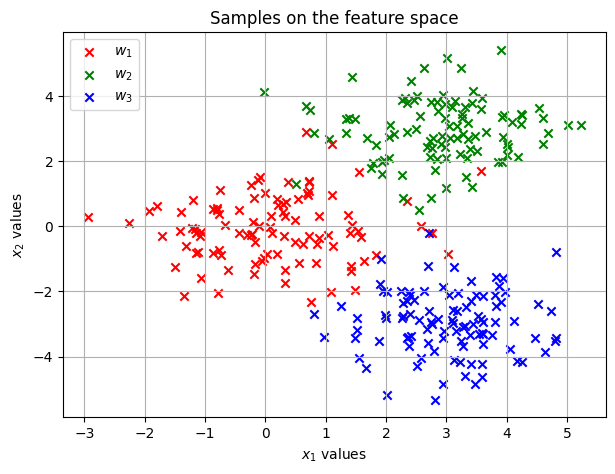

In [ ]:
plt.figure(figsize=(7, 5))

plt.scatter(w1[0], w1[1], color='r', marker='x', label=r'$w_1$')
plt.scatter(w2[0], w2[1], color='g', marker='x', label=r'$w_2$')
plt.scatter(w3[0], w3[1], color='b', marker='x', label=r'$w_3$')

plt.title('Samples on the feature space')
plt.xlabel("$x_1$ values")
plt.ylabel("$x_2$ values")
plt.legend()
plt.grid(True)
plt.show()

### **Α.**

Για την εκτίμηση των pdf $p(x|ω_1)$, $p(x|ω_2)$ και $p(x|ω_3)$ μέσω της μεθόδου παραθύρων Parzen χρησιμοποιείται συνάρτηση παραθύρου

$φ(x-x_i)=\frac{1}{(2π)^{d/2}}e^{-\frac{||x-x_i||_{L2}^2}{2}}$

για την εκτίμηση της pdf μέσω της σχέσης $p_N(x)=\frac{1}{N}∑_{i=1}^{N}{\frac{1}{h_N^d}φ(x-x_i)}$

Για $d=2$ (δύο χαρακτηριστικά: $x_1$ και $x_2$) και κανονικοποίηση με $h_N$ έχουμε συνάρτηση παραθύρου

$φ(\frac{x-x_i}{h_N})=\frac{1}{2π}e^{-\frac{||x-x_i||_{L2}^2}{2h_N^2}}$

και pdf

$p_N(x)=\frac{1}{N}∑_{i=1}^{N}{\frac{1}{h_N^2}φ(\frac{x-x_i}{h_N})}$

In [4]:
def parzen_window(diffs, h_N):

  dist_L2 = np.sum(diffs ** 2, axis = 2)

  return  np.exp(-dist_L2 / (2 * h_N ** 2)) / (2 * np.pi)


In [5]:
def parzen_pdf(X, x_i, h_N):

  diffs = X[:, np.newaxis, :] - x_i[np.newaxis, :, :]

  phi = parzen_window(diffs, h_N)
  pdf = np.mean(phi, axis=1) / h_N ** 2

  return pdf


Ορισμός συνάρτησης για τον σχεδιασμό γραφικής παράστασης της pdf της κάθε κλάσης στον χώρο των χαρακτηριστικών. Και οι 3 pdf είναι σε κοινά διαγράμματα, ένα 2D και ένα 3D με προσανατολισμό (1,1,1).

In [6]:
def pdf_graph_3D(xx1, xx2, classes_w, class_pdfs, method_param, method=0):

  """ method == 1 for k-NN and method_param -> k
      method == 0 (default) for Parzen Windows and method_param -> h_N """


  fig = plt.figure(figsize=(14, 6))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.scatter(classes_w[0][0], classes_w[0][1], color='r', marker='x', label=r'$w_1$', alpha=0.45)
  ax1.scatter(classes_w[1][0], classes_w[1][1], color='g', marker='x', label=r'$w_2$', alpha=0.45)
  ax1.scatter(classes_w[2][0], classes_w[2][1], color='b', marker='x', label=r'$w_3$', alpha=0.45)

  ax1.contour(xx1, xx2, class_pdfs[0], levels=15, cmap = 'Reds')
  ax1.contour(xx1, xx2, class_pdfs[1], levels=15, cmap = 'Greens')
  ax1.contour(xx1, xx2, class_pdfs[2], levels=15, cmap = 'Blues')

  if method:
    ax1.set_title(f"PDFs of all classes (k-NN method, $k$={method_param})")
  else:
    ax1.set_title(f"PDFs of all classes (Parzen Windows method, $h_N$={method_param})")
  ax1.set_xlabel("$x_1$ values")
  ax1.set_ylabel("$x_2$ values")
  ax1.legend()
  ax1.grid(True)


  ax2 = fig.add_subplot(1, 2, 2, projection='3d')
  ax2.plot_surface(xx1, xx2, class_pdfs[0], cmap='Reds', alpha=0.4, linewidth=0, antialiased=True)
  ax2.plot_surface(xx1, xx2, class_pdfs[1], cmap='Greens', alpha=0.4, linewidth=0, antialiased=True)
  ax2.plot_surface(xx1, xx2, class_pdfs[2], cmap='Blues', alpha=0.4, linewidth=0, antialiased=True)

  ax2.scatter(classes_w[0][0], classes_w[0][1], 0, color='r', marker='x', label='$w_1$')
  ax2.scatter(classes_w[1][0], classes_w[1][1], 0, color='g', marker='x', label='$w_2$')
  ax2.scatter(classes_w[2][0], classes_w[2][1], 0, color='b', marker='x', label='$w_3$')

  if method:
    ax2.set_title(f"PDFs of all classes (k-NN method, $k$={method_param}) in (1,1,1) view")
  else:
    ax2.set_title(f"PDFs of all classes (Parzen Windows method, $h_N$={method_param}) in (1,1,1) view")
  ax2.set_xlabel("$x_1$ values")
  ax2.set_ylabel("$x_2$ values")
  ax2.set_zlabel("Propability Density")
  ax2.view_init(elev=30, azim=45)
  ax2.legend()

  plt.show()


Εφαρμογή της μεθόδου παραθύρων Parzen για καθεμία από της κλάσεις σε όλο το πλήθος των δεδομένων του "Data_exercise1.csv" για $h_N=0.3$, $h_N=0.7$ και $h_N=0.1$. Απεικόνιση και των τριών υπολογισμένων pdf μέσω της *pdf_graph_3D* και για τις τρεις τιμές του $h_N$.

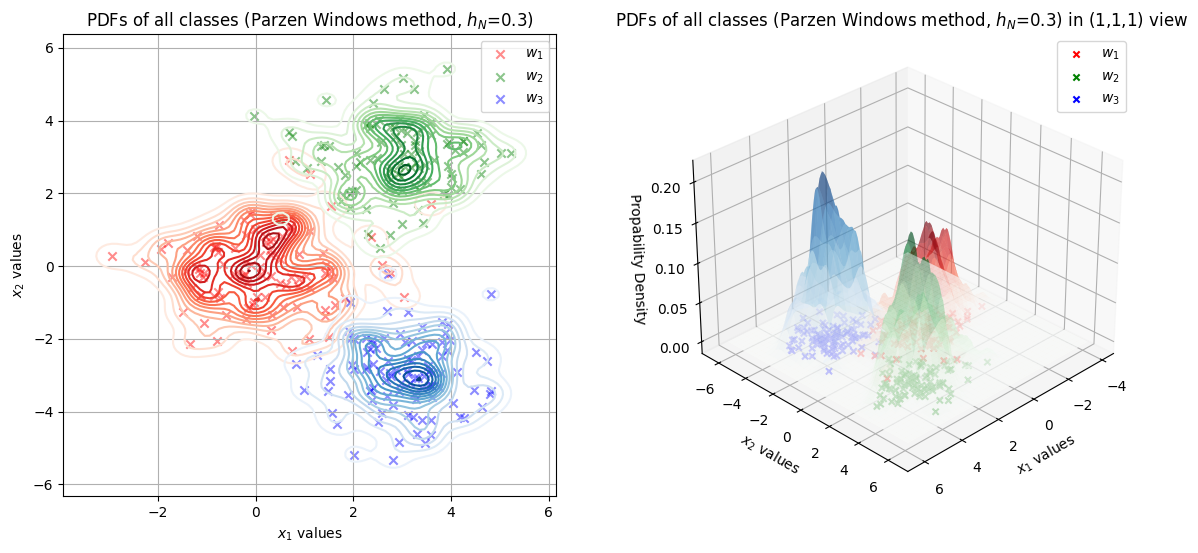

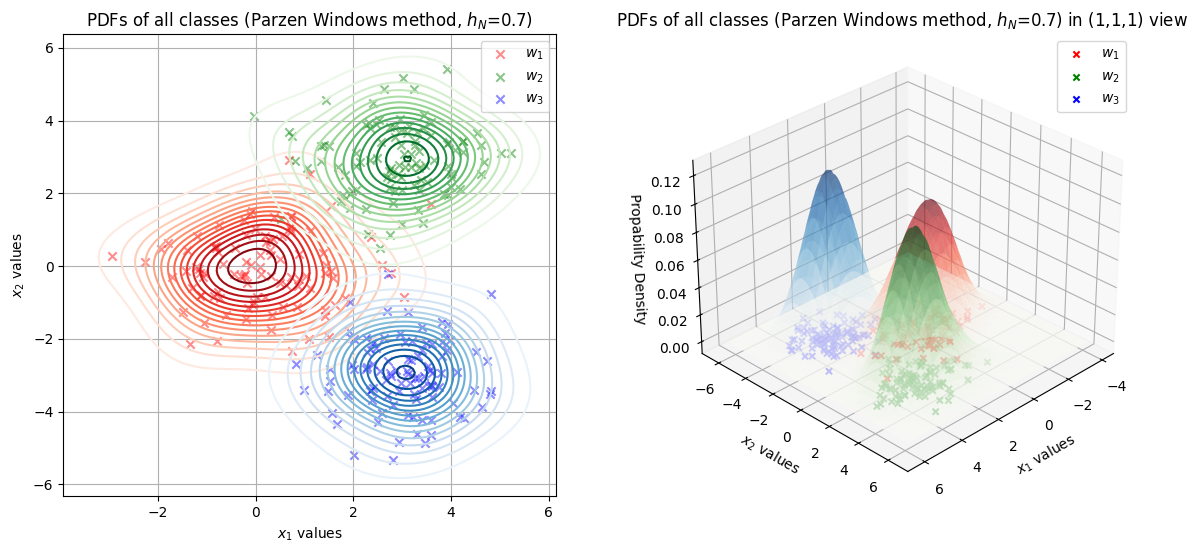

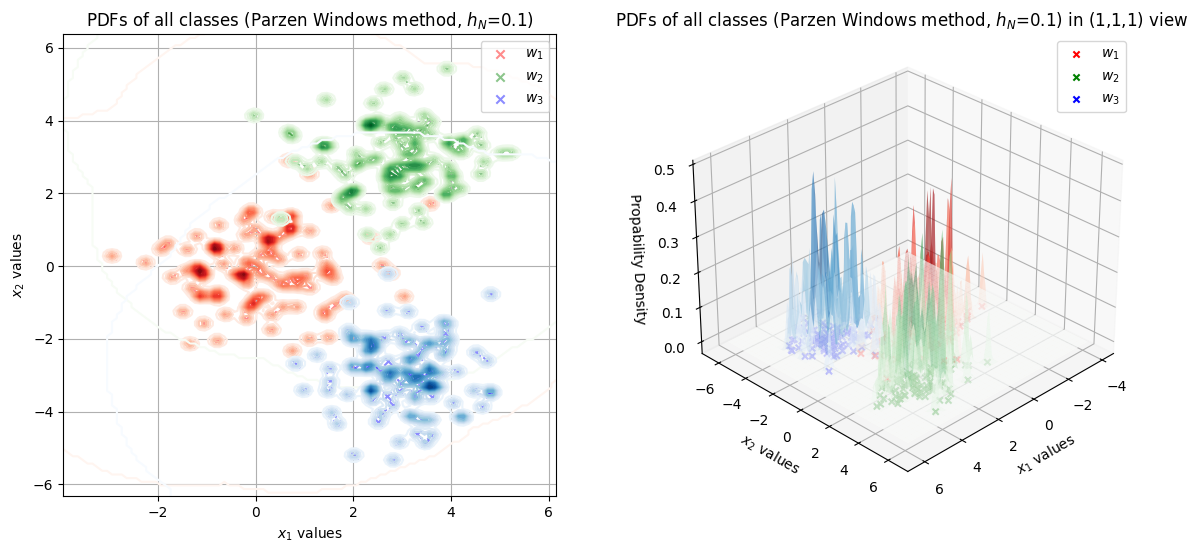

In [7]:
h_N = [0.3, 0.7, 0.1]

x1 = np.arange(df[0].min()-1, df[0].max()+1, 0.1)
x2 = np.arange(df[1].min()-1, df[1].max()+1, 0.1)

xx1, xx2 = np.meshgrid(x1,x2)
X = np.column_stack((xx1.ravel(), xx2.ravel()))

classes_w = [w1, w2, w3]
class_pdfs=[]            # For saving for later the pdfs calculated with h_N=0.3
for h in h_N:

    p_1 = parzen_pdf(X, w1[[0,1]].to_numpy(), h).reshape(xx1.shape)
    p_2 = parzen_pdf(X, w2[[0,1]].to_numpy(), h).reshape(xx1.shape)
    p_3 = parzen_pdf(X, w3[[0,1]].to_numpy(), h).reshape(xx1.shape)

    if h == h_N[0]:

        class_pdfs.append(p_1)
        class_pdfs.append(p_2)
        class_pdfs.append(p_3)

    pdf_graph_3D(xx1, xx2, classes_w, [p_1, p_2, p_3], h, 0)


Για κάθε μια από τις τιμές του $h_N$ (τιμή standard deviation) παρατηρούμε μέσω των διαγραμμάτων διαφορετικά επίπεδα προσαρμογής των κανονικών κατανομών στα δεδομένα. Πιο συγκεκριμένα:

*   Για $h_N=0.7$ παρατηρείται ότι η τελική pdf της κάθε κλάσης αδυνατεί να "αγκαλιάσει" σωστά τα δεδομένα. Η τελική pdf καταλαμβάνει όπως θα έπρεπε την περιοχή στην οποία είναι διασκορπισμένα τα δείγματα της, με την κορυφή της να είναι στο κέντρο του cluster, αλλά δεν διαθέτει τα τοπικά μέγιστα και τις ιδιομορφίες που προκαλούν τα διασκορπισμένα δειγματα. Με λίγα λόγια παρατηρείται underfitting της τελικής επιφάνειας στα δεδομένα. Αυτό οφείλεται στο ότι η τυπική απόκλιση $h_N$ των συστατικών κανονικών κατανομών (καθεμία με κέντρο ένα από τα δείγματα) είναι τόσο μεγάλη, ωστέ να αλληλοεπικαλύπτονται υπερβολικά και έτσι η υπέρθεση τους να μην διαθέτει ιδιαίτερα χαρακτηριστικά, όπως κορυφές.

*   Για $h_N=0.1$ η τελική επιφάνεια της pdf της κάθε κλάσης "αγκαλιάζει" τα δείγματα σε υπερβολικό βαθμό. Δηλαδή, αντί να υπάρχει μια επιφάνεια με κάποιες εντός ορίων ιδιομορφίες, δημιοργείται μια pdf η οποία στην θέση του κάθε δείγματος χαρακτηρίζεται από μία ψηλή και πολύ απότομη κορυφή. Αυτό είναι το λεγόμενο overfitting, δηλαδή υπερπροσαρμογή της επιφάνειας στα δεδομένα και προκαλείται επειδή η τυπική απόκλιση $h_N$ είναι τόσο μικρή, ώστε οι συνιστώσες κανονικές κατανομές να μην αλληλοεπικαλύπτονται καθόλου και άρα η υπέρθεση τους να είναι απλώς όλες οι κανονικές κατανομές διαχωρισμένες.  

*   Η εφαρμογή της μεθόδου με $h_N=0.3$ βρίσκεται αναμέσα στις δύο παραπάνω περιπτώσεις προσφέροντας μια επιφάνεια που ακολουθεί αρκετά καλά τα δεδομένα, έτσι ώστε να χαρακτηρίζεται από τις ιδιομορφίες που δεν διαθέτει μια underfitted επιφάνεια αλλά και ταυτόχρονα να μην υπάρχουν οι αποτόμες και απομονωμένες κορυφές του overfitting.

Επιλογή με τυχαίο τρόπο του 25% του συνολικού dataset (stratified, δηλαδή 25% από κάθε κλάση) για την εκ νέου εφαρμογή της μεθόδου παραθύρων Parzen.

In [8]:
data_percentage = 0.25         # Percentage of data to keep
rand_seed = 10                 # Seed for reproducibility

w1_size = int(w1.shape[0] * data_percentage)
w2_size = int(w2.shape[0] * data_percentage)
w3_size = int(w3.shape[0] * data_percentage)

w1_reduced = shuffle(w1, random_state=rand_seed, n_samples=w1_size)
w2_reduced = shuffle(w2, random_state=rand_seed, n_samples=w2_size)
w3_reduced = shuffle(w3, random_state=rand_seed, n_samples=w3_size)


print('\n-------------- Randomly Reduced Class 1: -------------')
print(w1_reduced)

print('\n-------------- Randomly Reduced Class 2: -------------')
print(w2_reduced)

print('\n-------------- Randomly Reduced Class 3: -------------')
print(w3_reduced)


-------------- Randomly Reduced Class 1: -------------
          0        1  2
19  1.41720 -1.20780  1
14  0.71474  0.96095  1
43  0.31286 -0.28565  1
37 -0.75493  1.12750  1
66 -1.49160 -1.25710  1
3   0.86217 -0.54453  1
79 -0.19605  0.86202  1
41 -0.24145 -0.26200  1
38  1.37030  0.35018  1
68 -1.06160 -0.17653  1
2  -2.25880  0.10009  1
1   1.83390 -0.88803  1
60 -1.08910 -0.29375  1
53 -1.11350 -0.79816  1
95  0.18733  0.82606  1
74 -0.76485  0.39135  1
92  0.72225 -0.30311  1
26  0.72689  1.09840  1
59  1.11740 -0.58903  1
46 -0.16488 -1.15640  1
90 -1.14800 -0.19522  1
70 -0.61560 -1.33200  1
50 -0.86365  0.52006  1
44 -0.86488 -0.83137  1
76 -1.42240 -0.13028  1

-------------- Randomly Reduced Class 2: -------------
            0        1  2
119  2.751000  3.82570  2
114  2.288000  0.87634  2
143  2.971000  3.74770  2
137 -0.029177  4.13850  2
166  3.471600  2.76610  2
103  3.307100  3.67700  2
179  2.945100  4.03600  2
141  3.933700  2.74490  2
138  2.543000  0.50311  2
168 

Αναπάρασταση των επιλεγμένων δειγμάτων στον χώρο των χαρακτηριστικών.

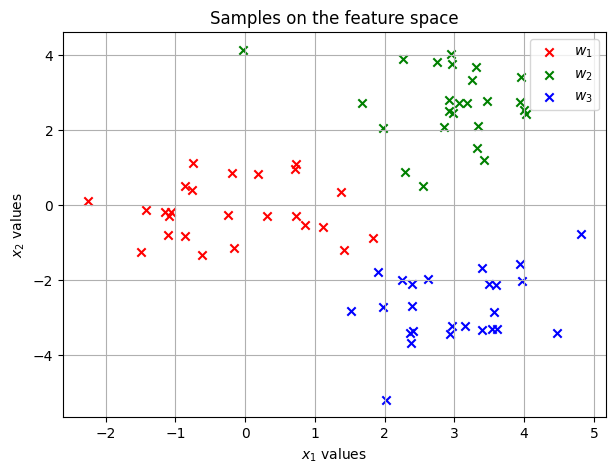

In [9]:
plt.figure(figsize=(7, 5))

plt.scatter(w1_reduced[0], w1_reduced[1], color='r', marker='x', label='$w_1$')
plt.scatter(w2_reduced[0], w2_reduced[1], color='g', marker='x', label='$w_2$')
plt.scatter(w3_reduced[0], w3_reduced[1], color='b', marker='x', label='$w_3$')

plt.title('Samples on the feature space')
plt.xlabel("$x_1$ values")
plt.ylabel("$x_2$ values")
plt.legend()
plt.grid(True)
plt.show()

Όπως φαίνεται μετά την εκτέλση του επόμενου code block, η εφαρμογή της μεθόδου παραθύρων Parzen με $h_N=0.3$ πάνω στο 25% του αρχικού dataset οδηγεί χειρότερα αποτελέσματα. Πιο συγκεκριμένα, επειδή τα δεδομένα είναι πιο διάσπαρτα, δεν επικαλύπονται οι συνιστώσες κατανομές καλά μεταξύ τους και έτσι η υπέρθεση τους εμφανίζει λίγο τα χαρακτηριστικά μιας overfitted επιφάνειας, όπως εξηγήθηκε παραπάνω.

Επομένως, είναι αναγκαίο να αυξηθεί το $h_N$, έτσι ώστε οι κάθε κατανομή να καταλαμβάνει μεγαλύτερο χώρο και επομένως να αλληλοεπικαλύπτονται καλύτερα.

Το πόσο θα πρέπει να αυξηθεί η $h_N$ μπορεί να προσεγγιστεί από τον κανόνα του Silverman [1] στις 2 διαστάσεις:

$h=σ̂ N^{-1/6}$, (γενική μορφή για $d$ διαστάσεις: $h=σ̂ N^{-1/(d+4)}$)

Θεωρώντας ότι η αφαίρεση του 75% των δεδομένων δεν επηρέασε σημαντικά την τυπική απόκλιση των δεδομένων (προσέγγιση), η νέα std του Gaussian kernel $h_Ν'$ θεωρείται ίση με:

$\frac{h_Ν}{h_Ν'}=\frac{σ̂ N^{-1/6}}{σ̂ 'N'^{-1/6}}⇒\frac{h_Ν}{h_Ν'}≈\frac{N^{-1/6}}{N'^{-1/6}}⇒h_Ν'≈h_Ν(\frac{N}{N'})^{1/6}⇒h_Ν'≈0.3(\frac{100}{25})^{1/6}⇒h_Ν'≈0.378$

Άρα για να έχουμε παρόμοια αποτελέσματα στο μειωμένο dataset, πρέπει η $h_N'$ των παραθύρων να ίση με $0.378$.

Aπό την εκτέλεση του παρακάτω code block επιβεβαιώνεται ότι η νέα τιμή $h_N'=0.378$ βελτιώνει σημαντικά την εκτίμηση. Αν και έχει διαφορές με εκείνη σε ολόκληρο το dataset (κάτι το οποίο είναι αναμενόμενο, δεδομένου ότι χάθηκαν δεδομένα) την προσεγγίζει σε ικανοποιητικό βαθμό.

[1] T. Chonavel, Machine Learning Kernel Methods, IMT Atlantique, slides. [Online]. Available: https://www.imt-atlantique.fr/sites/default/files/users/user896/SLIDES_kernel_methods.pdf

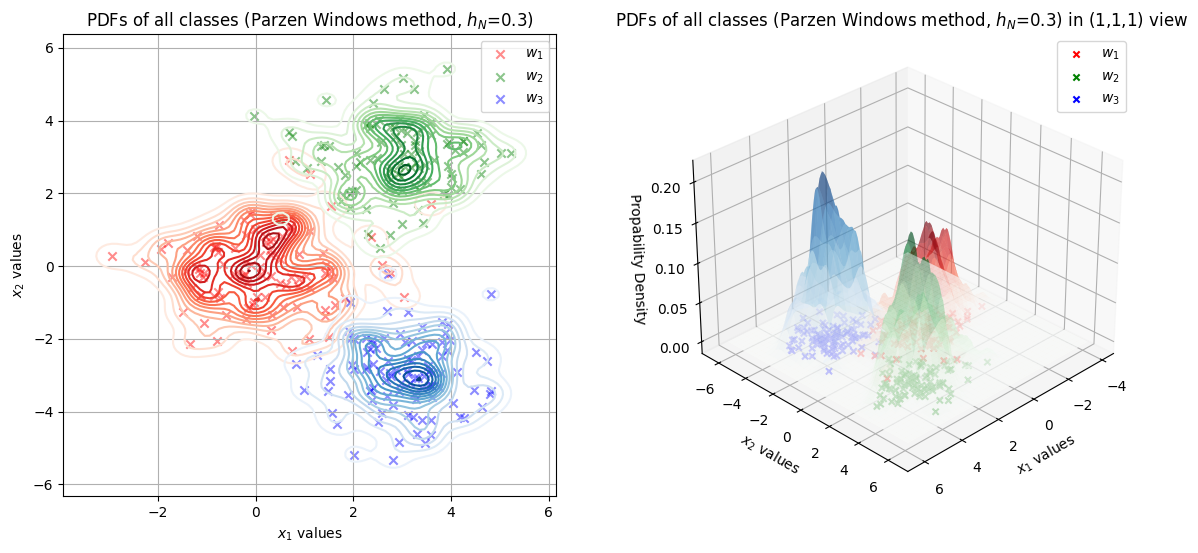

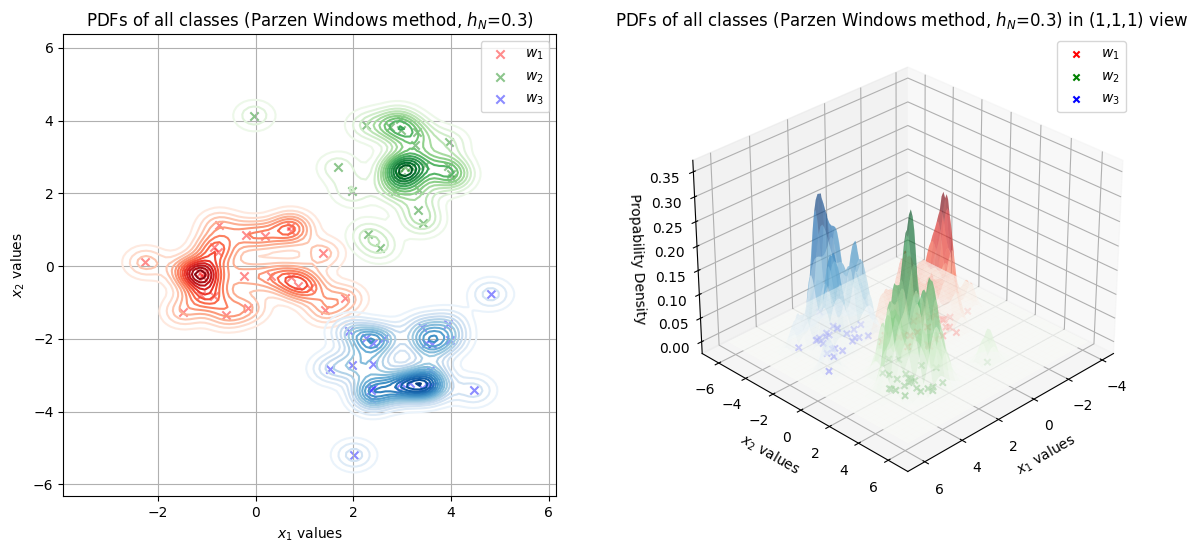

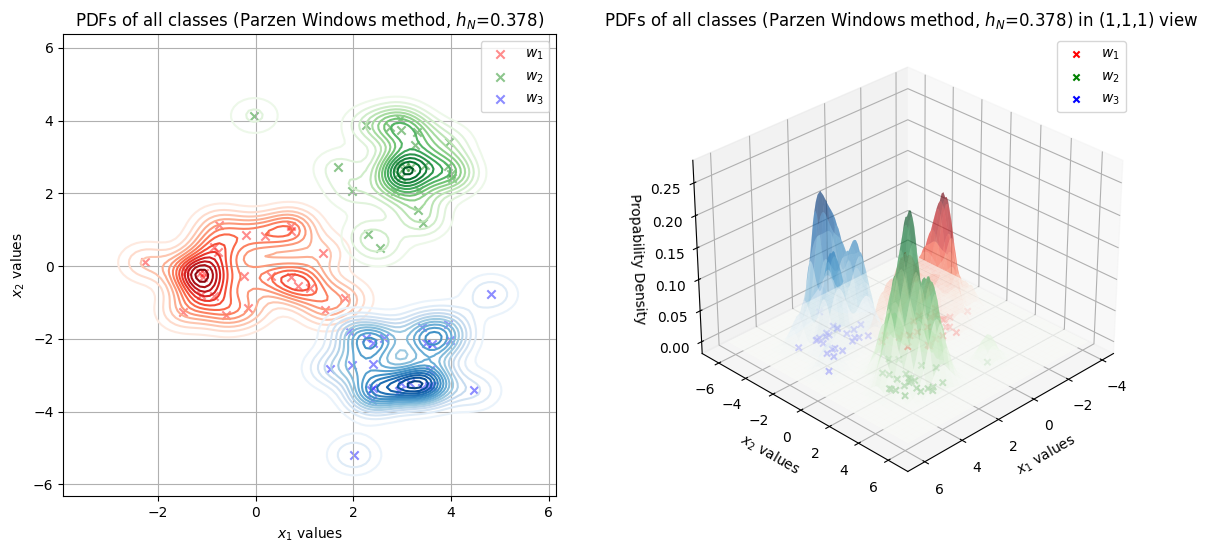

In [10]:
h_N_old = 0.3
h_N_new = 0.378

# The line below recreates the previous pdf diagrams (h_N = 0.3) for comparison.
pdf_graph_3D(xx1, xx2, classes_w, class_pdfs, h_N_old, 0)

classes_w_reduced = [w1_reduced, w2_reduced, w3_reduced]
p_1_reduced = parzen_pdf(X, w1_reduced[[0,1]].to_numpy(), h_N_old).reshape(xx1.shape)
p_2_reduced = parzen_pdf(X, w2_reduced[[0,1]].to_numpy(), h_N_old).reshape(xx1.shape)
p_3_reduced = parzen_pdf(X, w3_reduced[[0,1]].to_numpy(), h_N_old).reshape(xx1.shape)

pdf_graph_3D(xx1, xx2, classes_w_reduced, [p_1_reduced, p_2_reduced, p_3_reduced], h_N_old, 0)

p_1_reduced_new = parzen_pdf(X, w1_reduced[[0,1]].to_numpy(), h_N_new).reshape(xx1.shape)
p_2_reduced_new = parzen_pdf(X, w2_reduced[[0,1]].to_numpy(), h_N_new).reshape(xx1.shape)
p_3_reduced_new = parzen_pdf(X, w3_reduced[[0,1]].to_numpy(), h_N_new).reshape(xx1.shape)

pdf_graph_3D(xx1, xx2, classes_w_reduced, [p_1_reduced_new, p_2_reduced_new, p_3_reduced_new],
             h_N_new, 0)



### **Β.**

Για τον υπολογισμό των pdf $p(x|ω_1)$, $p(x|ω_2)$ και $p(x|ω_3)$ με την μέθοδο k-NN υπάρχουν δύο πιθανές προσεγγίσεις:

$1)$ Βρίσκουμε τους $k$ πλησιέστερους γείτονες του σημείου $x$ ανεξάρτητα από την τάξη στην οποία ανήκουν. Θέτουμε ως $r$ την απόσταση του $x$ από τον k-οστό γείτονα, η οποία ορίζει την (κυκλική για ευκλείδεια απόσταση L2) περιοχή γειτόνων με επιφάνεια (επιφάνεια, αντί για όγκο επειδή έχουμε 2 χαρακτηριστικά) $Α=π⋅r^2$.

Ισχύει: $p(x,ω_i)=\frac{k_i/n}{A}$ με $k_i$ τον αριθμό των γειτόνων από τους $k$ που ανήκουν στην κλάση $i$ και $n$ τον συνολικό αριθμό των δειγμάτων όλων των κλάσεων.

Επίσης ισχύει $P(ω_i)=N_i/n$

Επομένως: $p(x|ω_i)=\frac{p(x,ω_i)}{P(ω_i)}=\frac{k_i}{n⋅A⋅\frac{N_i}{n}}=\frac{k_i}{N_i⋅A}=\frac{k_i}{N_i⋅π⋅r^2}$


$2)$ Βρίσκουμε τους $k$ πλησιέστερους γείτονες του σημείου $x$ που ανήκουν **μόνο** στην κλάση $i$. Θέτουμε ως $r_i$ την απόσταση του $x$ από τον k-οστό γείτονα, η οποία ορίζει την (κυκλική) περιοχή γειτόνων κλάσης $i$ με επιφάνεια $Α_i=π⋅r_i^2$.

Ισχύει: $p(x,ω_i)=\frac{k/n}{A_i}$ με $n$ τον συνολικό αριθμό των δειγμάτων όλων των κλάσεων.

Επομένως: $p(x|ω_i)=\frac{p(x,ω_i)}{P(ω_i)}=\frac{k}{n⋅A_i⋅\frac{N_i}{n}}=\frac{k}{N_i⋅A}=\frac{k}{N_i⋅π⋅r_i^2}$

Από τις δύο παραπάνω μεθοδολογίες επιλέγεται η *2)* επειδή χρειάζεται μόνο τα δείγματα της κλάσης $i$ για να υπολογίσει το $p(x|ω_i)$, ενώ με την *1)* απαιτείται όλο το Dataset.

Ορισμός της μεθόδου k-NN με βάση με την μεθοδολογία *2)* για την υπολογισμό της pdf $p(x|ω_i)$. Οι αποστάσεις μετριούνται μέσω την ευκλείδεια απόσταση L2.

In [11]:
def knn_pdf(X, x_i, k):

  N_i = len(x_i)

  nbrs = NearestNeighbors(n_neighbors=k).fit(x_i)
  distances, _ = nbrs.kneighbors(X)

  r_i = distances[:, -1]
  pdf = k / (N_i * np.pi * r_i**2)

  return pdf


Εφαρμογή της μεθόδου k-NN για καθεμία από της κλάσεις για $k=10$, $k=3$ και $k=30$. Απεικόνιση και των τριών υπολογισμένων pdf μέσω της *pdf_graph_3D* και για τις τρεις τιμές του $k$.

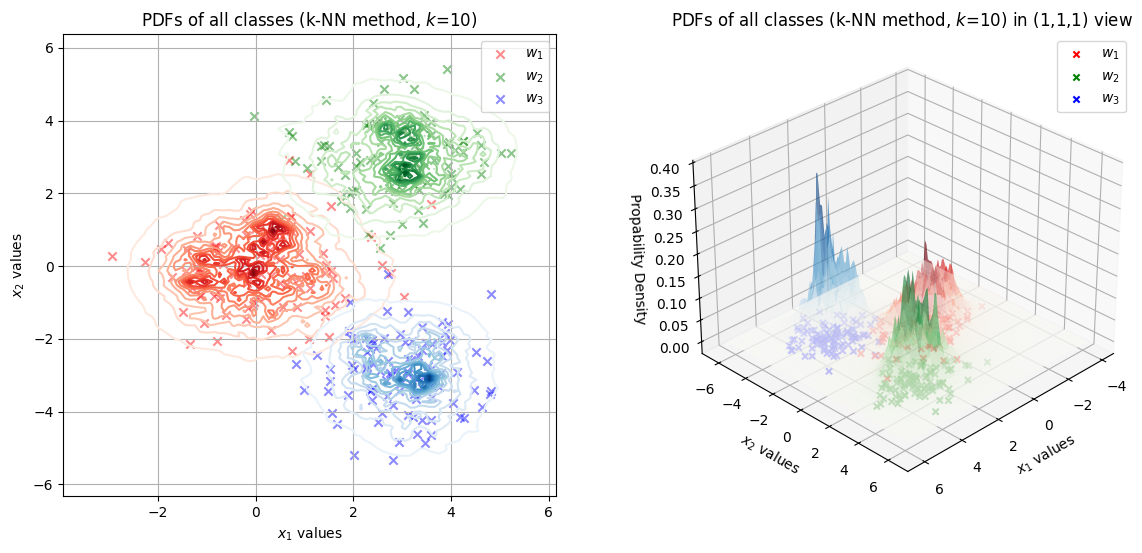

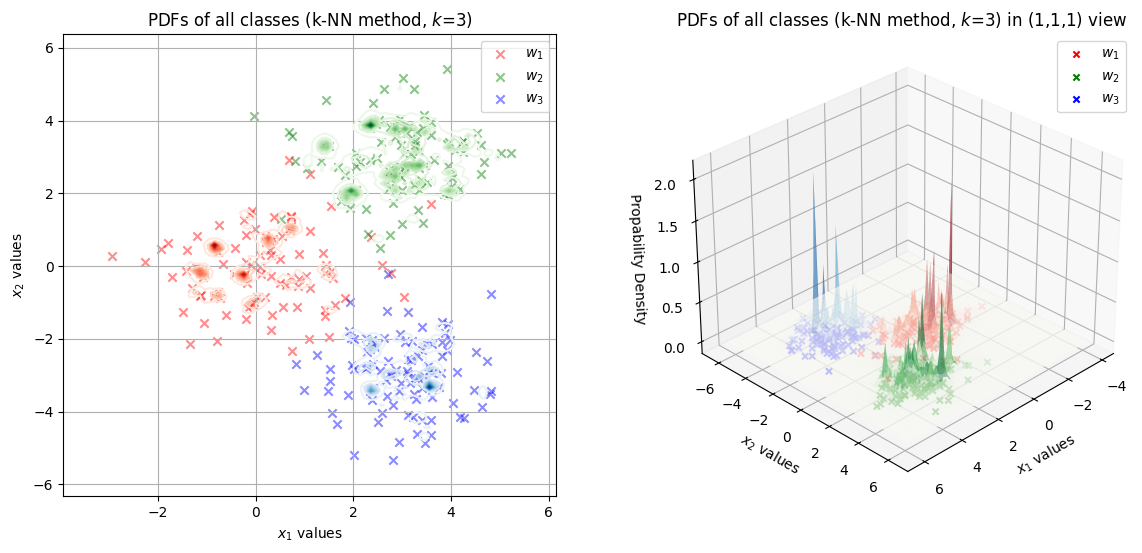

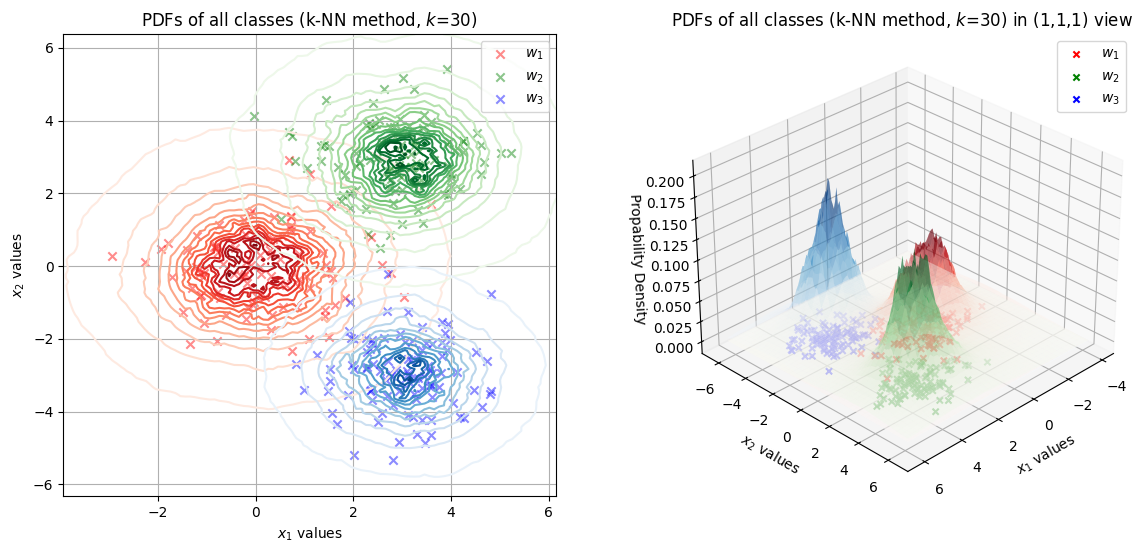

In [12]:
k = [10, 3, 30]

for kappa in k:

    p_1 = knn_pdf(X, w1[[0,1]].to_numpy(), kappa).reshape(xx1.shape)
    p_2 = knn_pdf(X, w2[[0,1]].to_numpy(), kappa).reshape(xx1.shape)
    p_3 = knn_pdf(X, w3[[0,1]].to_numpy(), kappa).reshape(xx1.shape)

    pdf_graph_3D(xx1, xx2, classes_w, [p_1, p_2, p_3], kappa, 1)


Για κάθε μια από τις τιμές του $k$ παρατηρούμε μέσω των διαγραμμάτων διαφορετικά επίπεδα προσαρμογής στα δεδομένα. Πιο συγκεκριμένα:

*   Για $k=3$ παρατηρείται ότι η τελική pdf της κάθε κλάσης χαρακτηρίζεται από απότομα στενά spikes, κάτι το οποίο αντιστοιχεί σε overfit. Αυτό συμβαίνει διότι στις περιοχές με πολλά δεδομένα, όσο μικρότερο το $k$, τόσο μικρότερη συνήθως η απόσταση $r_i$ από τον k-οστό γείτονα και επομένως μικρότερη επιφάνεια $A_i$ και άρα μεγαλύτερος λόγος $p(x|ω_i)=\frac{k}{N_i⋅π⋅r_i^2}$.

*   Για $k=30$ συμβαίνει το ακριβώς αντίστροφο, δηλαδή η τελική επιφάνεια της pdf δεν διαθέτει αρκετά έντονες ιδιομορφίες, κάτι που αντιστοιχεί σε underfit. Πλεόν το $k$ είναι τόσο μεγάλο, ώστε η απόσταση $r_i$ από τον k-οστό γείτονα να είναι σταθερά μεγάλη και επομένως ο λόγος $p(x|ω_i)=\frac{k}{N_i⋅π⋅r_i^2}$ σταθερός/παρόμοιος στις περισσοτερες περιπτώσεις.

*   Η εφαρμογή της μεθόδου με $k=10$ βρίσκεται ανάμεσα στις δύο περιπτώσεις προσφέροντας ένα εντός οριών smoothing χωρίς να "εξαφανίζει" τα αναγκαία peaks. Δηλαδή το $k$ είναι αρκετά μεγάλο ώστε το $r_i$ να έχει μια λογική διακύμανση στα σημεία του 2D χώρου.

### **Γ.**

### **Δ.**

### **Ε.**

---

## **Άσκηση 2**

### **Α.**

### **Β.**

### **Γ.**

### **Δ.**

---

## **Άσκηση 3**

### **Α.**

### **Β.**

### **Γ.**

### **Δ.**

### **Ε.**